# Part 3: Serving

In this part we will user MLRun's **serving runtime** to deploy our trained models from the previous stage a `Voting Ensemble` using **max vote** logic.  
We will also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** we defined in the preveious stage.

By the end of this tutorial you’ll learn how to:
- Define a model class to load our models, run preprocessing and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using our `mock server`
- Deploy the function to the cluster and test it live

## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun

project_name_base = 'fraud-demo'

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name_base, context="./", user_project=True)

> 2021-09-10 01:52:58,501 [info] loaded project fraud-demo from MLRun DB


## Define Model Class
- Load models
- Predict from the FS Online service via the `source` key

In [2]:
# mlrun: start-code

In [3]:
import os
from typing import Optional

import numpy as np
import pandas as pd
from cloudpickle import load
import json

import mlrun
from mlrun.serving.v2_serving import V2ModelServer


class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [4]:
# mlrun: end-code

## Define Serving Function
- Gather ClassifierModel code from this notebook
- Define `VotingEnsemble` - Max-Vote based ensemble
- Add models to the ensemble

In [5]:
project.set_model_monitoring_credentials(os.getenv('V3IO_ACCESS_KEY'))

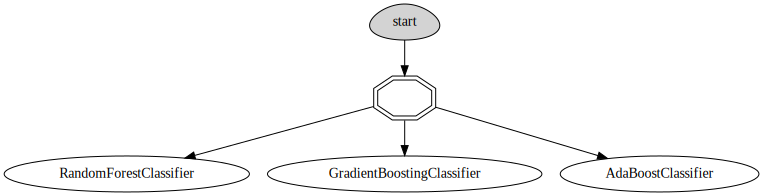

In [6]:
# Create the serving function from our code above
# namespace/image_name:tag
fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun")

# Model-monitoring
fn.set_tracking()

# 
fn.set_topology('router',
                'mlrun.serving.routers.EnrichmentVotingEnsemble',
                name='VotingEnsemble',
                feature_vector_uri="transactions-fraud-short",
                impute_policy={"*": "$mean"})

model_names = [
'RandomForestClassifier',
'GradientBoostingClassifier',
'AdaBoostClassifier'
]

models_dir = os.path.abspath('models')

for i, name in enumerate(model_names, start=1):
    fn.add_model(name, class_name="ClassifierModel", model_path=f"store://models/{project.name}/training_model#{i}:latest")

# Plot the ensemble configuration
fn.spec.graph.plot()

## Test the server locally

In [7]:
#server = fn.to_mock_server()

### Select a sample of the online features

In [8]:
import mlrun.feature_store as fstore

# Create the online feature service
svc = fstore.get_online_feature_service(f'{project.name}/transactions-fraud-short:latest')

# Get sample feature vector
sample_id = 'C76780537'
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': -inf,
  'amount_max_12h': 60.76,
  'amount_sum_2h': 0.0,
  'amount_count_2h': 0.0,
  'amount_avg_2h': nan}]

### Test using the sample

In [9]:
import json

# Send a sample ID for predcition
test_path = f'/v2/models/VotingEnsemble/infer'
test_sample = json.dumps({'inputs': [sample_id]})

In [10]:
#server.test(path=test_path,
#            body=test_sample)

## Deploy to the kubernetes cluster

In [11]:
addr = fn.deploy()

> 2021-09-10 01:53:03,767 [info] Starting remote function deploy
2021-09-10 01:53:05  (info) Deploying function
2021-09-10 01:53:05  (info) Building
2021-09-10 01:53:06  (info) Staging files and preparing base images
2021-09-10 01:53:06  (info) Building processor image
2021-09-10 01:53:07  (info) Build complete
2021-09-10 01:53:13  (info) Function deploy complete
> 2021-09-10 01:53:13,488 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-demo-admin-transaction-fraud-fraud-demo-admin.default-tenant.app.jnewriujxdig.iguazio-cd1.com/']}


## Add a stream

We can easily add a stream and send that to our function

### Create a stream

In [12]:
import v3io

container='projects'
stream_path = f'{project.name}/streams/transaction_fraud_stream'

# create stream
prediction_stream = f'v3io:///{container}/{stream_path}'
client = v3io.dataplane.Client()

client.stream.create(container='projects',
                     stream_path=stream_path,
                     shard_count=2,
                     raise_for_status=v3io.dataplane.transport.RaiseForStatus.never)

### Send a record to the stream

In [14]:
data = {'operation': 'infer',
        'model': 'VotingEnsemble',
        'inputs': [sample_id]}

rec = client.stream.put_records(container='projects',
                                stream_path=stream_path,
                                records=[{'data': json.dumps(data)}])

In [15]:
print(f'Number of records: {len(rec.output.records)}')
print(f'Number of failed records: {rec.output.failed_record_count}')

Number of records: 1
Number of failed records: 0


### Add a trigger to the function to receive data from the stream

In [16]:
fn.add_v3io_stream_trigger(prediction_stream)
fn.deploy()

> 2021-09-10 01:53:13,794 [info] Starting remote function deploy
2021-09-10 01:53:18  (info) Deploying function
2021-09-10 01:53:18  (info) Building
2021-09-10 01:53:19  (info) Staging files and preparing base images
2021-09-10 01:53:19  (info) Building processor image
2021-09-10 01:53:20  (info) Build complete
2021-09-10 01:53:26  (info) Function deploy complete
> 2021-09-10 01:53:26,672 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-demo-admin-transaction-fraud-fraud-demo-admin.default-tenant.app.jnewriujxdig.iguazio-cd1.com/']}


'http://fraud-demo-admin-transaction-fraud-fraud-demo-admin.default-tenant.app.jnewriujxdig.iguazio-cd1.com/'

## Simulate inocoming data

### Read a batch data sample

In [17]:
import pandas as pd
from random import choice

# Load the dataset
data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Sample 50k lines
data = data.sample(50000)

sample_ids = data['source'].to_list()

### Send data in a loop to simulate incoming data

In [18]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(4000):
    data_point = choice(sample_ids)
    try:
        fn.invoke(path=test_path, body=json.dumps({'inputs': [[data_point]]}))
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2021-09-10 01:53:29,533 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-09-10 01:53:31,066 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-09-10 01:53:31,668 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-09-10 01:53:33,377 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}
> 2021-09-10 01:53:34,537 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/VotingEnsemble/infer'}


KeyboardInterrupt: 